### Value at Risk

### 1 Historical Method with Python

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

### Установим время

In [2]:
years = 15

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=365*years)

### Создадим список тикеров

In [3]:
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

### Скачиваем для каждого скорректированные цены закрытия (Adjustead closed prices)

In [5]:
data = yf.download(ticker[0], start=startDate, end=endDate)

[*********************100%***********************]  1 of 1 completed


In [7]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start=startDate, end=endDate)
    adj_close_df[ticker] = data['Close']

adj_close_df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2010-04-22,91.965408,51.698200,111.839996,43.925369,47.387180
2010-04-23,92.565742,51.659149,113.190002,44.108719,47.707932
2010-04-26,92.216164,51.633110,112.750000,44.012661,47.539921
2010-04-27,90.035233,51.821926,114.629997,43.078461,46.394382
2010-04-28,90.719154,51.789368,114.309998,43.104649,46.699844
...,...,...,...,...,...
2025-04-11,533.940002,72.019997,297.929993,454.399994,261.739990
2025-04-14,539.119995,72.430000,296.230011,457.480011,264.149994
2025-04-15,537.609985,72.610001,297.779999,457.989990,263.690002


### Расчитаем дневную лог доходность и удалим пустые значения

In [8]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()
log_returns

,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2010-04-23,0.006507,-0.000756,0.011999,0.004165,0.006746
2010-04-26,-0.003784,-0.000504,-0.003895,-0.002180,-0.003528
2010-04-27,-0.023934,0.003650,0.016537,-0.021454,-0.024391
2010-04-28,0.007567,-0.000628,-0.002795,0.000608,0.006562
2010-04-29,0.012321,0.000378,-0.000262,0.017270,0.012998
...,...,...,...,...,...
2025-04-11,0.017686,-0.001110,0.018907,0.018255,0.016604
2025-04-14,0.009655,0.005677,-0.005722,0.006755,0.009165
2025-04-15,-0.002805,0.002482,0.005219,0.001114,-0.001743


### Создадим портфель с равными долями

In [9]:
portfolio_value = 1000000
weights = np.array([1/len(tickers)]*len(tickers))
weights

array([0.2, 0.2, 0.2, 0.2, 0.2])

### Рассчитаем историческую доходность портфеля (Calculate the historical portfolio returns)

In [10]:
historical_returns = (log_returns * weights).sum(axis =1)
historical_returns

Date
2010-04-23    0.005732
2010-04-26   -0.002778
2010-04-27   -0.009919
2010-04-28    0.002263
2010-04-29    0.008541
                ...   
2025-04-11    0.014068
2025-04-14    0.005106
2025-04-15    0.000853
2025-04-16   -0.007865
2025-04-17   -0.000653
Length: 3771, dtype: float64

In [18]:
days = 5

range_returns = historical_returns.rolling(window = days).sum()
range_returns = range_returns.dropna()
range_returns

Date
2010-04-29    0.003839
2010-04-30   -0.010289
2010-05-03    0.001055
2010-05-04   -0.005721
2010-05-05   -0.011365
                ...   
2025-04-11    0.043594
2025-04-14    0.055997
2025-04-15    0.066895
2025-04-16   -0.010674
2025-04-17    0.011510
Length: 3767, dtype: float64

In [19]:
confidence_interval = 0.95

VaR = -np.percentile(range_returns, 100 - (confidence_interval * 100))*portfolio_value
VaR

24336.635838509017

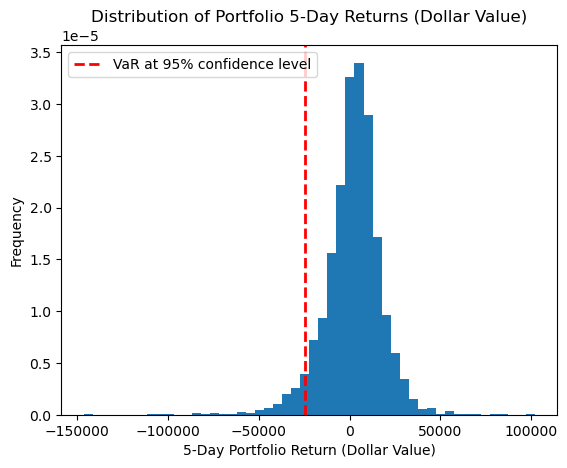

In [20]:
return_window = days
range_returns = historical_returns.rolling(window=return_window).sum()
range_returns = range_returns.dropna()

range_returns_dollar = range_returns * portfolio_value

plt.hist(range_returns_dollar.dropna(), bins=50, density=True)
plt.xlabel(f'{return_window}-Day Portfolio Return (Dollar Value)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio {return_window}-Day Returns (Dollar Value)')
plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence level')
plt.legend()
plt.show()

### 2 Parametric Method with Python

In [22]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

In [23]:
years = 15

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=365*years)

tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

In [28]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start=startDate, end=endDate)
    adj_close_df[ticker] = data['Close']

adj_close_df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2010-04-22,91.965446,51.698235,111.839996,43.925362,47.387177
2010-04-23,92.565788,51.659168,113.190002,44.108707,47.707928
2010-04-26,92.216194,51.633072,112.750000,44.012695,47.539925
2010-04-27,90.035225,51.821922,114.629997,43.078468,46.394382
2010-04-28,90.719177,51.789383,114.309998,43.104660,46.699871
...,...,...,...,...,...
2025-04-11,533.940002,72.019997,297.929993,454.399994,261.739990
2025-04-14,539.119995,72.430000,296.230011,457.480011,264.149994
2025-04-15,537.609985,72.610001,297.779999,457.989990,263.690002


In [29]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()
log_returns

,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2010-04-23,0.006507,-0.000756,0.011999,0.004165,0.006746
2010-04-26,-0.003784,-0.000505,-0.003895,-0.002179,-0.003528
2010-04-27,-0.023935,0.003651,0.016537,-0.021455,-0.024391
2010-04-28,0.007568,-0.000628,-0.002795,0.000608,0.006563
2010-04-29,0.012321,0.000377,-0.000262,0.017269,0.012997
...,...,...,...,...,...
2025-04-11,0.017686,-0.001110,0.018907,0.018255,0.016604
2025-04-14,0.009655,0.005677,-0.005722,0.006755,0.009165
2025-04-15,-0.002805,0.002482,0.005219,0.001114,-0.001743


In [30]:
portfolio_value = 1000000
weights = np.array([1/len(tickers)] * len(tickers))
weights

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [31]:
historical_returns = (log_returns * weights).sum(axis=1)
historical_returns

Date
2010-04-23    0.005732
2010-04-26   -0.002778
2010-04-27   -0.009919
2010-04-28    0.002263
2010-04-29    0.008540
                ...   
2025-04-11    0.014068
2025-04-14    0.005106
2025-04-15    0.000853
2025-04-16   -0.007865
2025-04-17   -0.000653
Length: 3771, dtype: float64

In [32]:
days = 5
historical_x_day_returns = historical_returns.rolling(window=days).sum()
historical_x_day_returns

Date
2010-04-23         NaN
2010-04-26         NaN
2010-04-27         NaN
2010-04-28         NaN
2010-04-29    0.003839
                ...   
2025-04-11    0.043594
2025-04-14    0.055997
2025-04-15    0.066895
2025-04-16   -0.010674
2025-04-17    0.011510
Length: 3771, dtype: float64

In [33]:
cov_matrix = log_returns.cov() * 252
cov_matrix

,SPY,BND,GLD,QQQ,VTI
SPY,0.030629,0.000073,0.001431,0.034179,0.031213
BND,0.000073,0.002397,0.002291,0.000272,0.000122
GLD,0.001431,0.002291,0.024117,0.001815,0.001567
QQQ,0.034179,0.000272,0.001815,0.043936,0.034837
VTI,0.031213,0.000122,0.001567,0.034837,0.032056


In [34]:
portfolio_std_dev = np.sqrt(weights.T @ cov_matrix @ weights)
portfolio_std_dev

0.11810717111724954

In [ ]:
# confidence_levels = [0.90, 0.95, 0.99]

# VaRs = []
# for cl in confidence_levels:
#     VaR = portfolio_value * (norm.ppf(1 - cl) * portfolio_std_dev * np.sqrt(days / 252) - historical_returns.mean() * days)
#     VaRs.append(VaR)
# VaRs

[-23204.037005055838, -29248.098318597626, -40585.752165876984]

In [41]:
confidence_levels = [0.90, 0.95, 0.99]

VaRs = []
for cl in confidence_levels:
    VaR = portfolio_value * portfolio_std_dev * norm._ppf(cl) * np.sqrt(days / 252)
    VaRs.append(VaR)
VaRs

[21320.485242010032, 27364.546555551824, 38702.20040283118]

In [42]:
print(f'{"Confidence Level":<20} {"Value at Risk":<20}')
print('-' * 40)

for cl, VaR in zip(confidence_levels, VaRs):
    print(f'{cl * 100:>6.0f}%: {"":<8} ${VaR:>10,.2f}')

Confidence Level     Value at Risk       
----------------------------------------
    90%:          $ 21,320.49
    95%:          $ 27,364.55
    99%:          $ 38,702.20


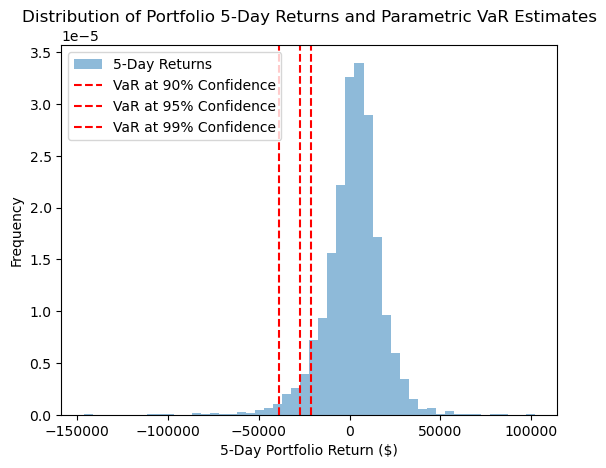

In [43]:
# Convert returns to dollar values for the histogram
historical_x_day_returns_dollar = historical_x_day_returns * portfolio_value

# Plot the histogram
plt.hist(historical_x_day_returns_dollar, bins=50, density=True, alpha=0.5, label=f'{days}-Day Returns')

# Add vertical lines representing VaR at each confidence level
for cl, VaR in zip(confidence_levels, VaRs):
    plt.axvline(x=-VaR, linestyle='--', color='r', label='VaR at {}% Confidence'.format(int(cl * 100)))

plt.xlabel(f'{days}-Day Portfolio Return ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio {days}-Day Returns and Parametric VaR Estimates')
plt.legend()
plt.show()

### 3 Monte Carlo Method with Python

In [44]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

In [45]:
### Set time from to a certain number of years
years = 15

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 365*years)

### Create a list of tickers
tickers = ['SPY','BND','GLD','QQQ','VTI']

In [46]:
### Download the daily adjusted close prices for the tickers
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start = startDate, end = endDate)
    adj_close_df[ticker] = data['Close']

adj_close_df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2010-04-22,91.965416,51.698215,111.839996,43.925369,47.387169
2010-04-23,92.565781,51.659161,113.190002,44.108727,47.707920
2010-04-26,92.216194,51.633121,112.750000,44.012684,47.539913
2010-04-27,90.035233,51.821907,114.629997,43.078468,46.394375
2010-04-28,90.719177,51.789364,114.309998,43.104652,46.699863
...,...,...,...,...,...
2025-04-11,533.940002,72.019997,297.929993,454.399994,261.739990
2025-04-14,539.119995,72.430000,296.230011,457.480011,264.149994
2025-04-15,537.609985,72.610001,297.779999,457.989990,263.690002


In [47]:
### Calculate the daily log returns and drop any NAs
log_returns = np.log(adj_close_df/adj_close_df.shift(1))
log_returns  = log_returns.dropna()

log_returns

,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2010-04-23,0.006507,-0.000756,0.011999,0.004166,0.006746
2010-04-26,-0.003784,-0.000504,-0.003895,-0.002180,-0.003528
2010-04-27,-0.023935,0.003650,0.016537,-0.021455,-0.024391
2010-04-28,0.007568,-0.000628,-0.002795,0.000608,0.006563
2010-04-29,0.012321,0.000377,-0.000262,0.017270,0.012997
...,...,...,...,...,...
2025-04-11,0.017686,-0.001110,0.018907,0.018255,0.016604
2025-04-14,0.009655,0.005677,-0.005722,0.006755,0.009165
2025-04-15,-0.002805,0.002482,0.005219,0.001114,-0.001743


In [55]:
### Create a function that will be used to calculate portfolio expected return
# We are assuming that future returns are based on past returns, which is not a reliable assumption.
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)

In [56]:
### Create a function that will be used to calculate portfolio standard deviation
def standard_deviation (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [49]:
### Create a covariance matrix for all the securities
cov_matrix = log_returns.cov()
cov_matrix

,SPY,BND,GLD,QQQ,VTI
SPY,1.215426e-04,2.898827e-07,0.000006,0.000136,1.238592e-04
BND,2.898827e-07,9.512777e-06,0.000009,0.000001,4.828705e-07
GLD,5.680381e-06,9.089360e-06,0.000096,0.000007,6.216567e-06
QQQ,1.356305e-04,1.080292e-06,0.000007,0.000174,1.382435e-04
VTI,1.238592e-04,4.828705e-07,0.000006,0.000138,1.272067e-04


In [50]:
### Create an equally weighted portfolio and find total portfolio expected return and standard deviation
portfolio_value = 1000000
weights = np.array([1/len(tickers)]*len(tickers))
portfolio_expected_return = expected_return(weights, log_returns)
portfolio_std_dev = standard_deviation (weights, cov_matrix)

In [51]:
def random_z_score():
    return np.random.normal(0, 1)

### Create a function to calculate scenarioGainLoss
days = 20

def scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days):
    return portfolio_value * portfolio_expected_return * days + portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)

In [52]:
### Run 10000 simulations
simulations = 10000
scenarioReturn = []

for i in range(simulations):
    z_score = random_z_score()
    scenarioReturn.append(scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days))

In [53]:
### Specify a confidence interval and calculate the Value at Risk (VaR)
confidence_interval = 0.99
VaR = -np.percentile(scenarioReturn, 100 * (1 - confidence_interval))
print(VaR)

70187.69053975698


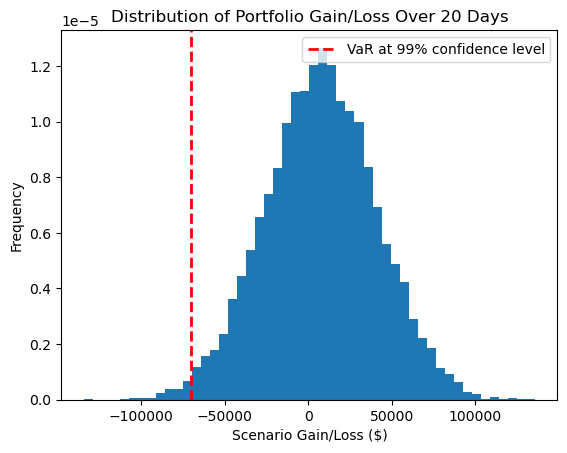

In [54]:
### Plot the results of all 10000 scenarios
plt.hist(scenarioReturn, bins=50, density=True)
plt.xlabel('Scenario Gain/Loss ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio Gain/Loss Over {days} Days')
plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence level')
plt.legend()
plt.show()